In [3]:
import pandas as pd
import numpy as np
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as vz
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config

In [2]:
config = config.config()
path = config['PATHS']

derived_path = path['derived_path']
all_tweet_data = path['all_tweet_data']

In [3]:
#thailand_092020
iran_202012_campaign = 'iran_202012'
year = '2020_12'
        
ops_file_path = os.path.join(path, 'all_tweets', year, 
                       iran_202012_campaign, f'{iran_202012_campaign}_tweets.pkl.gz')
control_file_path = os.path.join(path, 'all_tweets', year, 
                            iran_202012_campaign, 'DriversControl', 
                            f'{iran_202012_campaign}_control.pkl.gz')

data = read_ops_control_data(ops_file_path, 
                             control_file_path,
                             includes=['ops']
                            )
df_ops = data['ops']

In [1]:
# df_ops.info()

### **Creating coordination graph in replying to users**

In [4]:
def convert_tweetids_to_string(df_time, field='tweetid',
                               filter_threshold=False,
                               threshold=None
                              ) -> pd.DataFrame:
    '''
    Converts the time binned tweets to single single dataframe and convert the tweets \
    to single document tweets for each users
    
    :param df_time: dictionary of time binned dataframes
    
    :return pandas dataframe
    '''

    df_time = df_time.astype({field: int})
    df_time = df_time.astype({field: str})
    
    df_time = (df_time
                   .groupby('userid')[field]
                   .apply(list)
                   .reset_index(name='tweet_ids'))
        
    if filter_threshold:
        df_time = df_time.loc[df_time['tweet_ids'].map(len) > threshold]
        
    
    df_time['tweet_ids'] = df_time['tweet_ids'].apply(lambda x: ' '.join(x))
    
    return df_time

In [5]:
def coordination_reply(df, output_path, campaign_name):
    print('\n----- Start: Filtering tweets ---------')
    df = filter_reply_count(df, 5)
    print('----- End: Filtering tweets ---------\n')
    
    print('\n----- Start: Create bi-partite network -----')
    df_network = create_user_projection(df, 'in_reply_to_userid')
    print('\n----- End: Create bi-partite network -----')
    
    print('\n----- Start: Create co-reply strings  -----')
    df_string = convert_tweetids_to_string(df, 
                                           field='in_reply_to_userid')
    print('\n----- End: Create co-reply strings -----')
    
    print('\n----- Start: Calculate tfidf vector -----')
    df_string = calculate_tf_idf_vector(df_string)
    print('\n------ End: Calculate tfidf vector -----')
    
    print('\n----- Start: Retweet user projection network ------')
    df_new = calculate_cosine_similarity(df_network, df_string)
    print('\n----- End: Retweet user projection network -----')
       
    pkl_path = os.path.join(output_path, 
                            f'{campaign_name}_network.pkl.gz')
    
    df_new.to_pickle(f'{pkl_path}')
    
    print('\n ----- Start: Create co-retweet graph -----')
    create_graph(df_new, 
                 output_path,
                 campaign_name=campaign_name,
                 source_column='source',
                 target_column='target',
                 weight_column='cosine',
                 type_text='co-reply')
    print(f'----- End: Creating user projection network ---------\n')
        
    return df_new

In [6]:
create_folder(save_path, 'reply_coordination')

coordination_path = os.path.join(save_path, 
                                 'reply_coordination')
total_path = os.path.join(save_path, 
                          'reply_coordination', 
                          f'{iran_202012_campaign}_network.pkl.gz')

if os.path.isfile(total_path) == False:
    df_ops = reply_to_external_users(df_ops)
    df_coordination = coordination_reply(df_ops, 
                                         coordination_path,
                                         iran_202012_campaign)
    
    #Top 5% users
    per_5 = int(len(df_coordination) * 0.05)

    df_coordination = df_coordination.sort_values(by=['cosine'],
                                                  ascending=False
                                                 )

    df_head = df_coordination.head(per_5)

    users = list(set(list(df_head['source']) + list(df_head['target'])))

    print('Total unique users: ', len(users))   


    #Text for manual inspection
    df_text_user_1 = df_ops.loc[df_ops['userid'].isin(df_head['source'])][['in_reply_to_userid',
                                              'in_reply_to_tweetid',
                                              'userid', 'tweet_text'
                                             ]]
    df_text_user_1 = df_text_user_1.sort_values(by=['in_reply_to_userid', 
                                      'in_reply_to_tweetid',
                                      'userid', 'tweet_text'
                                     ])

    df_text_user_2 = df_ops.loc[df_ops['userid'].isin(df_head['target'])][['in_reply_to_userid',
                                              'in_reply_to_tweetid',
                                              'userid', 'tweet_text'
                                             ]]
    df_text_user_2 = df_text_user_2.sort_values(by=['in_reply_to_userid', 
                                      'in_reply_to_tweetid',
                                      'userid', 'tweet_text'
                                     ])

    df_text = df_text_user_1.merge(df_text_user_2, 
                              on=['in_reply_to_userid', 
                                  'in_reply_to_tweetid'],
                             )

    df_text = df_text.loc[df_text['userid_x'] != df_text['userid_y']]

    df_text = df_text.fillna(0)

    df_text = df_text.astype({
        'in_reply_to_userid': int,
        'in_reply_to_tweetid': int
    })

    # df_text

    df_text.to_csv('test_reply_coordination_manual_insp.csv')

NameError: name 'create_folder' is not defined

In [11]:
#1 giant component

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6672 entries, 197 to 37471
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  6672 non-null   int64  
 1   target  6672 non-null   int64  
 2   cosine  6672 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 208.5 KB
None


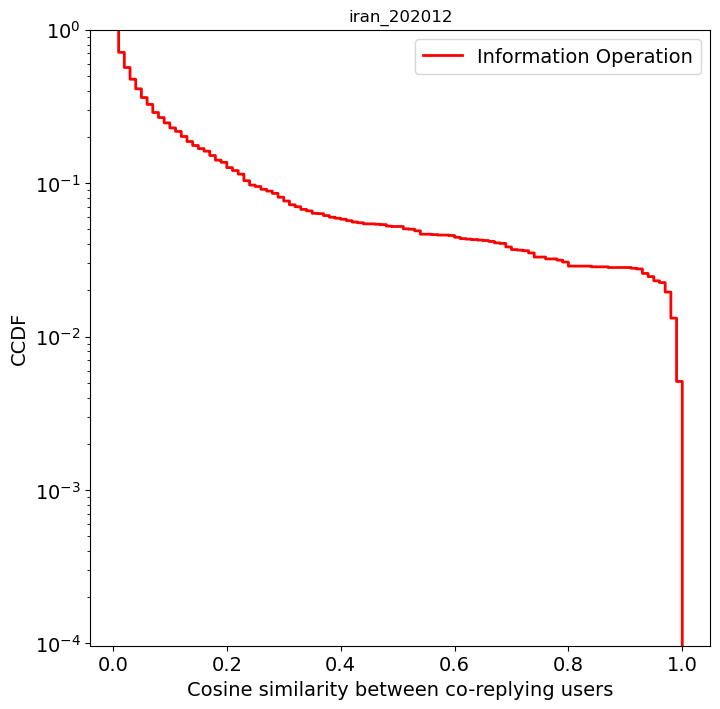

In [12]:
#Distribution of similiary between users replying
df_network = pd.read_pickle(total_path)

print(df_network.info())


cdf_parameters = {
        'data': [df_network],
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'cosine',
                'label': 'Information Operation',
                'mean': False
            },
        ],
        'x': 'Cosine similarity between co-replying users',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Cosine similarity between co-replying users',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        'random_color': False,
        'log_yscale': True,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_{iran_202012_campaign}_cosine_of_users_replying.png'
        }
    }

ccdf(cdf_parameters)

In [13]:
#Inspection of top 5% users in co-replying
df_text = pd.read_csv('test_reply_coordination_manual_insp.csv')

In [14]:
pd.options.display.max_colwidth = 200

df_text[['in_reply_to_tweetid', 'tweet_text_x']].head(100)

,in_reply_to_tweetid,tweet_text_x
0,1201969234726858752,@CNN Saudi kings have no fear of massacre of innocent Yemeni people increasing attacks day by day. #NATO
1,1201969234726858752,@CNN Saudi kings have no fear of massacre of innocent Yemeni people increasing attacks day by day. #NATO
2,1201969234726858752,@CNN The situation in Gaza is unstable and the people are not well and they are still suffering the hardest punishments.
3,1201969234726858752,@CNN leaders who manage #Gaza do not like people to be comfortable .They avoid helping them
4,1202263835517816832,@CNN All Yemeni children are suffering from malnutrition due to lack of water and food.
...,...,...
95,1207413086577209344,@CNN US personnel leave their embassy in #Iraq
96,1207413086577209344,@CNN US personnel leave their embassy in #Iraq
97,1207413086577209344,@CNN US personnel leave their embassy in #Iraq
98,1207413086577209344,@CNN #Israel wants to take a pawn and does not want to return #Palestinian bodies


### checking the number of users involved in
#replying to specific tweetid

In [15]:
#Get only replies

def unique_user_involved_in_reply(df_ops, column_name='count'):
    '''
    Gets the count of users involved in replying to tweets
    
    :param df_ops: dataframe
    :param column_name: name of the column that has count data

    :return Dataframe
    '''
    df_only_reply = df_ops.loc[~df_ops['in_reply_to_tweetid'].isnull()]
    df_only_reply = df_only_reply.loc[df_only_reply['in_reply_to_tweetid'] != 0]
    df_only_reply = reply_to_external_users(df_only_reply)
    #Groupby the reply_to_tweetid
    df_reply_dist = (df_only_reply
                     .groupby(['in_reply_to_tweetid'])['userid']
                     .apply(lambda x: list(set(x)))
                     .to_frame('userid_list')
                     .reset_index()
                    )

    df_reply_dist['count'] = df_reply_dist['userid_list'].apply(
        lambda x: len(x))

    print('Maximum reply a tweet got :', df_reply_dist['count'].max())
    
    return df_reply_dist

In [16]:
df_reply_dist = unique_user_involved_in_reply(df_ops)

df_reply_dist['count'].max()

Maximum reply a tweet got : 6


6

In [17]:
len(df_reply_dist.loc[df_reply_dist['count'] >= 2])

2842

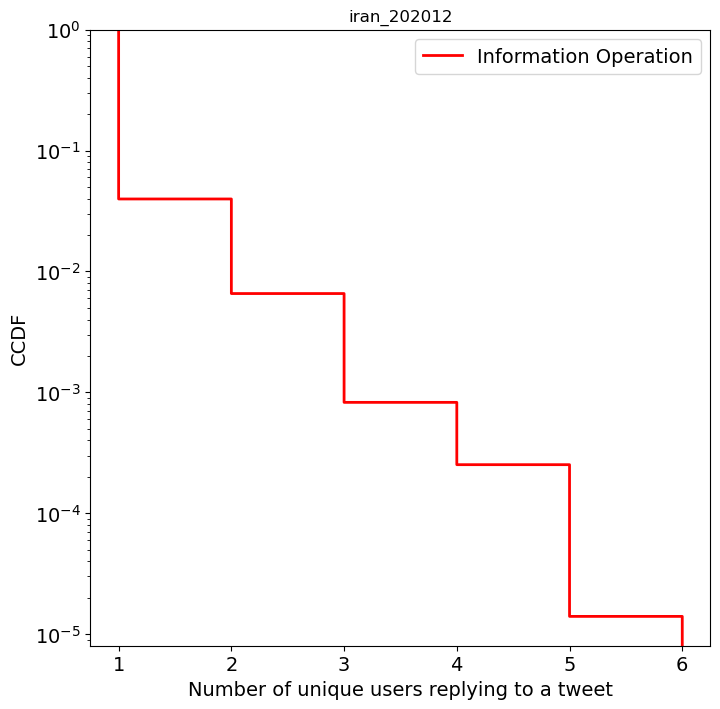

In [18]:
#Checking even if there are sufficient number of users replying

cdf_parameters = {
        'data': [df_reply_dist],
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'count',
                'label': 'Information Operation',
                'mean': False
            },
        ],
        'x': 'Percentage of replies to external account \n to total tweets for each account',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Number of unique users replying to a tweet',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        'random_color': False,
        'log_yscale': True,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_{iran_202012_campaign}_number_of_users_replying.png'
        }
    }

ccdf(cdf_parameters)


 ------ CNHU_0621 ------- 

31269
1148
Maximum reply a tweet got : 37

 ------ CNCC_0621 ------- 

35924
12648
Maximum reply a tweet got : 1

 ------ MX_0621 ------- 

19277
3999
Maximum reply a tweet got : 31

 ------ REA_0621 ------- 

7723
181
Maximum reply a tweet got : 1

 ------ RNA_0621 ------- 

18958
2844
Maximum reply a tweet got : 3

 ------ Tanzania_0621 ------- 

20212
12712
Maximum reply a tweet got : 4

 ------ uganda_0621 ------- 

524081
118476
Maximum reply a tweet got : 50

 ------ Venezuela_0621 ------- 

860060
76017
Maximum reply a tweet got : 64

 ------ armenia_202012 ------- 

72960
245
Maximum reply a tweet got : 4

 ------ GRU_202012 ------- 

26684
2569
Maximum reply a tweet got : 2

 ------ IRA_202012 ------- 

68914
4879
Maximum reply a tweet got : 2

 ------ iran_202012 ------- 

560571
81213
Maximum reply a tweet got : 6

 ------ ira_092020 ------- 

1368
71
Maximum reply a tweet got : 1

 ------ iran_092020 ------- 

2450
663
Maximum reply a tweet got 

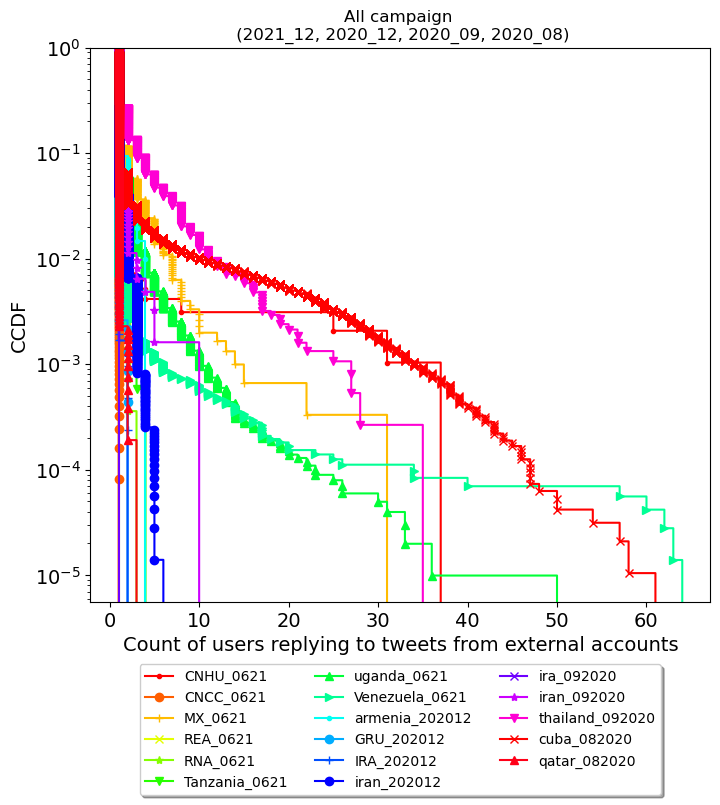

In [19]:
#considering the replies for some campaign
campaigns = {
    # '2021_12': ['Venezuela_0621', ],
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
}

all_replies = []
for year in campaigns:
    for new_campaign in campaigns[year]:
        print(f'\n ------ {new_campaign} ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               new_campaign, f'{new_campaign}_tweets.pkl.gz')
        control_file_path = None
        
        data_new = read_ops_control_data(ops_file_path, 
                                     control_file_path, 
                                     ['ops'])
        print(len(data_new['ops']))
        data_new['ops'] = reply_to_external_users(data_new['ops'])
        print(len(data_new['ops']))
        df_reply = unique_user_involved_in_reply(data_new['ops'])
        
        all_replies.append(df_reply)
        
columns = []

for year in campaigns:
    for new_campaign in campaigns[year]:
        columns.append({
            'column': 'count',
            'label': new_campaign,
            'mean': False
        })
        
multi_parameters = {
        'data': all_replies,
        'size': (25, 16),
        'fontsize': 14,
        'title': 'All campaign \n (2021_12, 2020_12, 2020_09, 2020_08)',
        'sharex': True,
        'sharey': True,
        'columns': columns,
        'x': 'Count of users replying to tweets from external accounts',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Count of users replying to tweets from external accounts',
        'ylabel': 'CCDF',
        # 'legend_location': 'upper right',
        'random_color': True,
        'log_yscale': True,
        'legend_lower': True,

        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_all_campaign_replying_user_count_outer.png'
        }
    }


ccdf_symbol(multi_parameters)

In [22]:
def bundle_campaign(all_campaigns=None,
                    bundle=None
                   ):
    '''
    Splits the campaign data into parts according to bundle list
    
    :param all_campaigns: dictionary of campaigns
    :param bundle: list of keys to split
    
    :return splited dictionary, concated names of keys
    '''
    
    if all_campaigns == None:
        all_campaigns = {
            '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                        'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                        'uganda_0621', 'Venezuela_0621'],
            '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 
                        'iran_202012'],
            '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
            '2020_08': ['cuba_082020', 'qatar_082020'],

            '2020_05' : [
                         'china_052020', 
                         'turkey_052020',
                         'russia_052020' #incomplete control data
                        ],
            '2020_04' : ['egypt_022020', 'honduras_022020',
                         'indonesia_022020', 'sa_eg_ae_022020',
                         'serbia_022020'],
            '2020_03': ['ghana_nigeria_032020'],
            '2019_11': ['saudi_arabia_112019'],
            '2019_08': ['china_082019',
                        'ecuador_082019', 
                        'egypt_uae_082019', 
                        # 'saudi_arabia_082019', 
                        'spain_082019',
                        'uae_082019'],
            '2019_06': ['catalonia_201906_1',
                        # 'russia_201906_1', #need checking
                        # 'iran_201906_1',
                        # 'iran_201906_2',
                        # 'iran_201906_3',
                        'venezuela_201906_1'
                       ],
            '2019_01': ['iran_201901_1', 
                        'russia_201901_1',
                        'bangladesh_201901_1',
                        'venezuela_201901',
                       ],
            '2018_10': ['ira', 'iranian'],
        }


    if bundle == None:
        bundle = [
            # ['2021_12', '2020_12', '2020_09', '2020_08'], 
            # ['2020_05', '2020_04', '2020_03', '2019_11'], 
            ['2019_08', '2019_06', '2019_01', '2018_10']
        ]
    
    names = []
    splits = []

    for row in bundle:
        split_bundle = {key: all_campaigns[key] for key in row}
        
        splits.append(split_bundle)
        names.append(','.join(row))
    
    return splits, names


 ------ china_082019 ------- 

25980563
6342274
Maximum reply a tweet got : 117

 ------ ecuador_082019 ------- 

700240
45303
Maximum reply a tweet got : 102

 ------ egypt_uae_082019 ------- 

214898
3504
Maximum reply a tweet got : 36

 ------ spain_082019 ------- 

56712
8617
Maximum reply a tweet got : 32

 ------ uae_082019 ------- 

1325530
90970
Maximum reply a tweet got : 206

 ------ catalonia_201906_1 ------- 

9489
2126
Maximum reply a tweet got : 4

 ------ venezuela_201906_1 ------- 

569453
125
Maximum reply a tweet got : 1

 ------ iran_201901_1 ------- 

13235923
483803
Maximum reply a tweet got : 18

 ------ russia_201901_1 ------- 

920761
71158
Maximum reply a tweet got : 3

 ------ bangladesh_201901_1 ------- 

26212
306
Maximum reply a tweet got : 1

 ------ venezuela_201901 ------- 

9935542
255484
Maximum reply a tweet got : 37

 ------ ira ------- 

8768633
221764
Maximum reply a tweet got : 18

 ------ iranian ------- 

1122936
331992
Maximum reply a tweet go

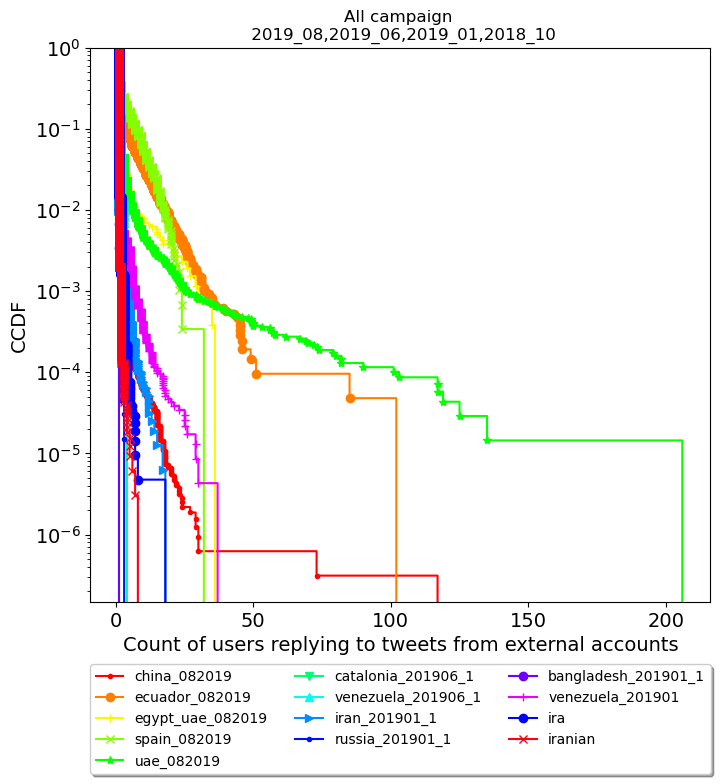

In [23]:
split_bundle, names = bundle_campaign()

for i, all_campaigns in enumerate(split_bundle):
    all_replies = []
    for year in all_campaigns:
        for new_campaign in all_campaigns[year]:
            print(f'\n ------ {new_campaign} ------- \n')

            ops_file_path = os.path.join(path, 'all_tweets', year, 
                                   new_campaign, f'{new_campaign}_tweets.pkl.gz')
            control_file_path = None

            data_new = read_ops_control_data(ops_file_path, 
                                         control_file_path, 
                                         ['ops'])
            
            if 'in_reply_to_tweetid' not in data_new['ops'].columns:
                continue
                
            print(len(data_new['ops']))
            data_new['ops'] = reply_to_external_users(data_new['ops'])
            print(len(data_new['ops']))
            df_reply = unique_user_involved_in_reply(data_new['ops'])

            all_replies.append(df_reply)

    columns = []

    for year in all_campaigns:
        for new_campaign in all_campaigns[year]:
            columns.append({
                'column': 'count',
                'label': new_campaign,
                'mean': False
            })
            
    name = names[i]
    
    multi_parameters = {
            'data': all_replies,
            'size': (25, 16),
            'fontsize': 14,
            'title': f'All campaign \n {name}',
            'sharex': True,
            'sharey': True,
            'columns': columns,
            'x': 'Count of users replying to tweets from external accounts',
            'complementary': True,
            'two_column': False,
            'xlabel': 'Count of users replying to tweets from external accounts',
            'ylabel': 'CCDF',
            # 'legend_location': 'upper right',
            'random_color': True,
            'log_yscale': True,
            'legend_lower': True,

            # 'log_xscale': False,
            'save': {
                'path': f'{plot_path}',
                'filename': f'ccdf_{name}_campaign_replying_user_count_outer.png'
            }
        }


    ccdf_symbol(multi_parameters)

### Considering control

In [ ]:
#considering the replies for some campaign
campaigns = {
    # '2021_12': ['Venezuela_0621', ],
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
}

all_replies = []
for year in campaigns:
    for new_campaign in campaigns[year]:
        print(f'\n ------ {new_campaign} ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               new_campaign, f'{new_campaign}_tweets.pkl.gz')
        control_file_path = os.path.join(path, 'all_tweets', year, 
                        new_campaign, 'DriversControl', 
                        f'{new_campaign}_control.pkl.gz')
        
        data_new = read_ops_control_data(ops_file_path, 
                                     control_file_path, 
                                     ['control'])
        
        # print(len(data_new['control']))
        # data_new['ops'] = reply_to_external_users(data_new['control'])
        # print(len(data_new['ops']))
        
        df_reply = unique_user_involved_in_reply(data_new['control'])
        
        all_replies.append(df_reply)
        
columns = []

for year in campaigns:
    for new_campaign in campaigns[year]:
        columns.append({
            'column': 'count',
            'label': new_campaign,
            'mean': False
        })
        
multi_parameters = {
        'data': all_replies,
        'size': (25, 16),
        'fontsize': 14,
        'title': 'All control \n (2021_12, 2020_12, 2020_09, 2020_08)',
        'sharex': True,
        'sharey': True,
        'columns': columns,
        'x': 'Count of users replying to tweets',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Count of users replying to tweets',
        'ylabel': 'CCDF',
        # 'legend_location': 'upper right',
        'random_color': True,
        'log_yscale': True,
        'legend_lower': True,

        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_all_control_replying_user_count.png'
        }
    }


ccdf_symbol(multi_parameters)

In [ ]:
#manual inspection 
#multiple replies to same user, 
#unrelated replies
#topics more related to middle east

In [ ]:
## How would you define a coordinated reply?
## Gain visibility
## Cases of harrashment
## Case of organic campaign

### Checking if the original tweets are available

In [ ]:
df_text = pd.read_csv('test_reply_coordination_manual_insp.csv')

In [ ]:
df_text.info()

In [ ]:
conversation_id_path = '/N/slate/potem'
file_name = 'conversation_ids.txt'
rows = df_text.loc[df_text['in_reply_to_tweetid'] != 0]['in_reply_to_tweetid'].unique()
path_with_name_of_file = os.path.join(conversation_id_path, file_name)

def write_to_file_row_each_line(path, file_name, 
                                rows):
    '''
    Writes each row as one line in file
    :param path: path where file is to be saved
    :param file_name: name of new file
    :param rows: list of row to be written
    '''
    
    path_with_name_of_file = os.path.join(path, file_name)

    with open(f'{path_with_name_of_file}', 'w') as f:
        for line in rows:
            f.write(f"{line}\n")
            
            
#write_to_file_row_each_line(conversation_id_path, file_name, rows)

##Run twarc2 after this
##twarc2 conversations conversation_ids.txt > conversation.jsonl

In [ ]:
#Result